## **ECON 470 Hwk4-3**

**Author:** Ilse Novis 

**Due Date:** 4/11/2025  

[GitHub Repository](https://github.com/ilsenovis18/ECON470HW4)

\newpage

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore")
import pyfixest as pf
from pyfixest.estimation import feols

final = pd.read_csv('/Users/ilsenovis/ECON470HW4/data/output/_final_ma_data.csv', low_memory=False)

# Summarize the Data

### Question 1: Remove all SNPs, 800-series plans, and prescription drug only plans (i.e., plans that do not offer Part C benefits)

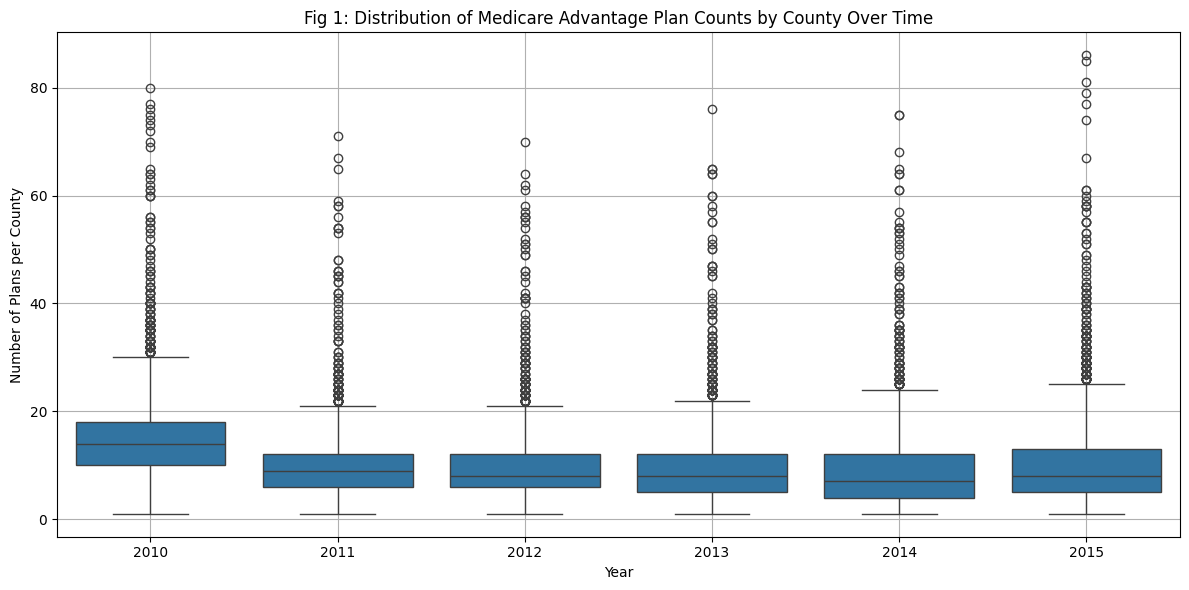

In [2]:
#filter out SNPs, 800, drug only
filtered = final[
    (final['snp'] == 'No') &
    ~((final['planid'] >= 800) & (final['planid'] < 900)) &
    (final['partd'] == 'Yes')  # Part C plans also include Part D
].copy()
 
 # Count plans per county per year
plan_counts = (
    filtered.groupby(['fips', 'year'])
    .agg(plan_count=('planid', 'nunique'))
    .reset_index()
)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=plan_counts, x='year', y='plan_count')
plt.title("Fig 1: Distribution of Medicare Advantage Plan Counts by County Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Plans per County")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Interpretation of Plan Availability (Question 1)

The boxplot showing the distribution of Medicare Advantage plan counts per county from 2010 to 2015 suggests considerable variation in the number of available plans:

- **Median Availability:** Most counties offer between **10 and 15** plans annually, indicating that most beneficiaries likely have **sufficient options** for choice.
- **Consistency over time:** The distribution is **stable across years**, showing that the number of plans available has not drastically changed from 2010 to 2015.
- **Outliers:** Some counties still offer **30-90+ plans**, which may reflect **overly saturated** markets where beneficiaries could face decision fatigue or marketing overload.
- **Low-plan counties:** A smaller number of counties consistently offer **fewer than 5 plans**, which may raise concerns about insufficient competition or choice in those areas.

**Conclusion**:  
> Overall, the number of plans appears **sufficient on average for most beneficiaries**, but the wide variation across counties implies that **some areas may have too many options**, while **others may be underserved**.

\newpage

### Question 2: Provide bar graphs showing the distribution of star ratings in 2010, 2012, and 2015. How has this distribution changed over time?

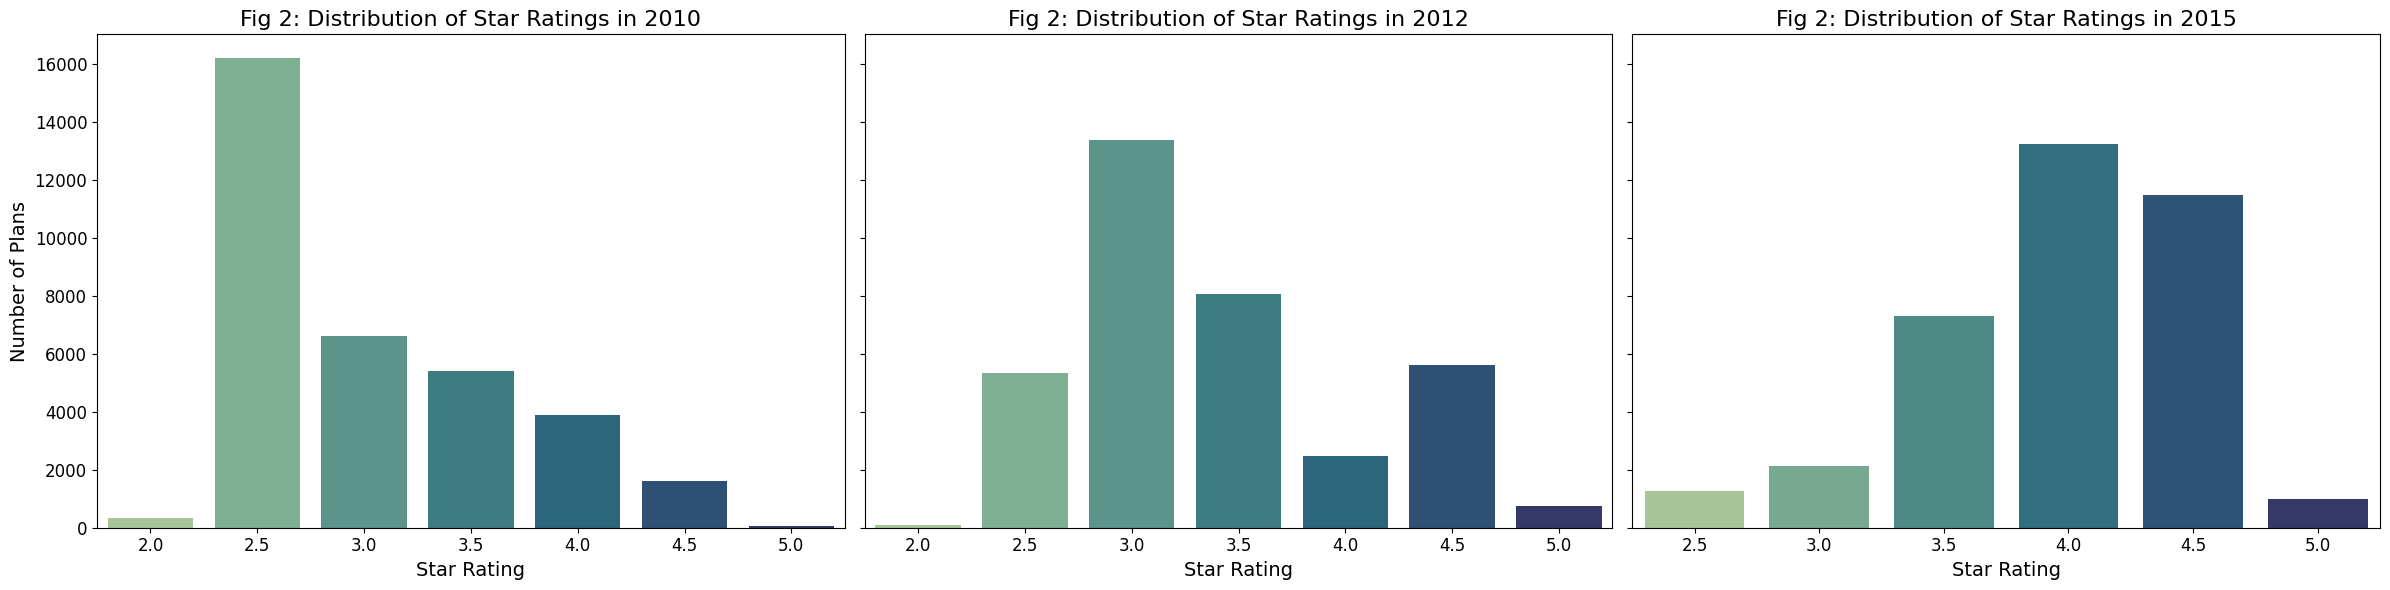

In [3]:
# Ensure numeric
filtered.loc[:, 'Star_Rating'] = pd.to_numeric(filtered['Star_Rating'], errors='coerce')
years = [2010, 2012, 2015]

# Create 1 row with 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    yearly_data = filtered[filtered['year'] == year]
    sns.countplot(
        data=yearly_data,
        x='Star_Rating',
        hue='Star_Rating',
        palette='crest',
        order=sorted(yearly_data['Star_Rating'].dropna().unique()),
        ax=ax,
        legend=False
    )
    ax.set_title(f"Fig 2: Distribution of Star Ratings in {year}", fontsize=16)
    ax.set_xlabel("Star Rating", fontsize=14)
    ax.set_ylabel("Number of Plans" if i == 0 else "", fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

#### Interpretation of Star Rating Distributions (Question 2)

The distribution of Medicare Advantage star ratings has changed **significantly** between 2010 and 2015:

- **2010**: The majority of plans were concentrated at the **2.5-star** level, with relatively few plans rated 4 stars or higher. This suggests **overall lower quality scores** in the earlier period.
  
- **2012**: There was a noticeable **shift upward** in ratings. The number of 3-star and 3.5-star plans increased, and more plans started receiving 4.5 stars. The 2.5-star peak diminished compared to 2010.

- **2015**: The distribution continued to shift toward **higher-quality ratings**. The modal rating moved to **4.0 stars**, with significant growth in 4.0 and 4.5-star plans. Plans rated below 3 stars became rare.

---

**Summary**:  
Over time, the distribution of star ratings **shifted upward**, reflecting either genuine improvements in plan performance, changes in CMS methodology, or both.

\newpage

### Question 3: Plot the average benchmark payment over time from 2010 through 2015. How much has the average benchmark payment risen over the years?

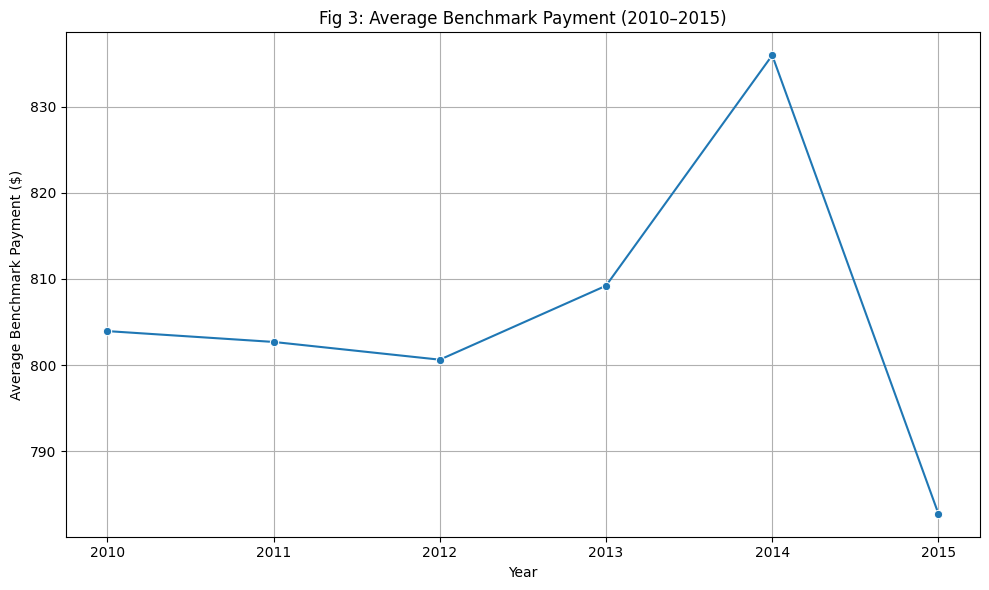


Increase from 2010 to 2015: $-21.23


In [4]:
# Ensure ma_rate is numeric
final["ma_rate"] = pd.to_numeric(final["ma_rate"], errors="coerce")

# Filter valid years and benchmark data
benchmark_trend = (
    final[(final['year'] >= 2010) & (final['year'] <= 2015) & (final['ma_rate'].notna())]
    .groupby("year", as_index=False)["ma_rate"]
    .mean()
)

# Plot average benchmark payment by year
plt.figure(figsize=(10, 6))
sns.lineplot(data=benchmark_trend, x="year", y="ma_rate", marker="o")
plt.title("Fig 3: Average Benchmark Payment (2010–2015)")
plt.xlabel("Year")
plt.ylabel("Average Benchmark Payment ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


growth = benchmark_trend['ma_rate'].iloc[-1] - benchmark_trend['ma_rate'].iloc[0]
print(f"\nIncrease from 2010 to 2015: ${growth:.2f}")

#### Change in Average Benchmark Payment (2010–2015)

Between 2010 and 2014, the average benchmark payment for Medicare Advantage plans **increased steadily**, reaching a peak of **$836.00** in 2014. However, in 2015 there was a sharp **drop** to **$782.71**.

- **2010 Benchmark**: $803.94  
- **2014 Benchmark**: $836.00  
- **2015 Benchmark**: $782.71  

**Overall Change (2010 to 2015)**:  
The average benchmark payment **decreased by $21.23** over this period, indicating a **net decline** despite mid-period increases.

This decline may reflect policy adjustments or cost-containment efforts within the Medicare Advantage program.

\newpage

### Question 4: Plot the average share of Medicare Advantage (relative to all Medicare eligibles) over time from 2010 through 2015. Has Medicare Advantage increased or decreased in popularity? How does this share correlate with benchmark payments?

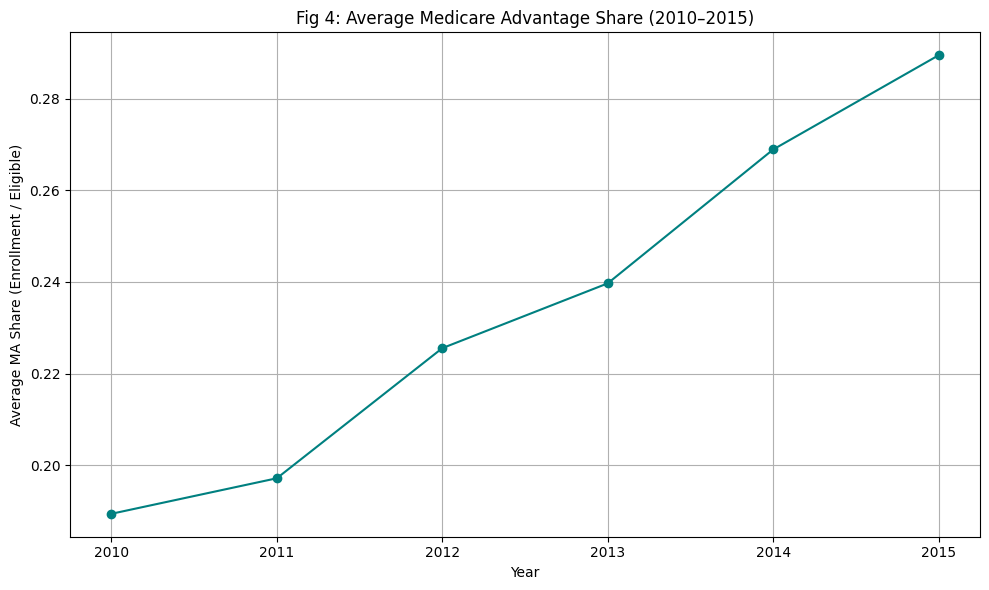

Correlation between MA Share and Benchmark Payment: 0.010


In [5]:
# Calculate Medicare Advantage (MA) share per plan
final["ma_share"] = final["avg_enrolled"] / final["avg_eligibles"]

# Group by year
avg_ma_share = final.groupby("year")["ma_share"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_ma_share["year"], avg_ma_share["ma_share"], marker='o', color='teal')
plt.title("Fig 4: Average Medicare Advantage Share (2010–2015)")
plt.xlabel("Year")
plt.ylabel("Average MA Share (Enrollment / Eligible)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Group by year and calculate average benchmark + MA share
grouped = final.groupby("year").agg({
    "ma_share": "mean",
    "ma_rate": "mean"
}).reset_index()

# Check correlation
correlation = grouped["ma_share"].corr(grouped["ma_rate"])
print(f"Correlation between MA Share and Benchmark Payment: {correlation:.3f}")

#### Popularity of Medicare Advantage and Its Relationship with Benchmark Payments

**Has Medicare Advantage Increased in Popularity?**  
Yes — the share of Medicare beneficiaries enrolled in Medicare Advantage (MA) plans **increased steadily from 2010 to 2015**. The MA share rose to nearly 29% by 2015, indicating growing popularity among eligible beneficiaries.

**How Does This Share Correlate with Benchmark Payments?**  
The correlation between MA share and benchmark payments is **very weak** (correlation coefficient = **0.010**), suggesting **virtually no linear relationship** between the two.

Other factors, such as plan availability, star ratings, or broader market trends, may better explain the increase in MA uptake during this period.

\newpage

## Estimate ATEs

### Question 5: Calculate the running variable underlying the star rating. Provide a table showing the number of plans that are rounded up into a 3-star, 3.5-star, 4-star, 4.5-star, and 5-star rating.

In [15]:
# Filter to 2010 only
data_2010 = final[final["year"] == 2010].copy()

# Recalculate domain_avg correctly
columns_to_average = [
    'breastcancer_screen', 'rectalcancer_screen', 'cv_cholscreen', 'glaucoma_test',
    'monitoring', 'flu_vaccine', 'pn_vaccine', 'physical_health',
    'mental_health', 'osteo_test', 'physical_monitor', 'primaryaccess',
    'osteo_manage', 'diab_cholscreen', 'diabetes_eye', 'diabetes_kidney',
    'diabetes_bloodsugar', 'diabetes_chol', 'bloodpressure', 'ra_manage',
    'copd_test', 'bladder', 'falling', 'nodelays', 'doctor_communicate',
    'carequickly', 'customer_service', 'overallrating_care',
    'overallrating_plan', 'complaints_plan', 'appeals_timely', 'appeals_review',
    'leave_plan', 'audit_problems', 'hold_times', 'info_accuracy', 'ttyt_available',
    'bmi_assess', 'older_medication', 'older_function', 'older_pain',
    'readmissions', 'access_problems', 'coordination', 'improve',
    'enroll_timely', 'specialneeds_manage'
]

# Recompute
ma_data_clean = (
    data_2010.copy()
    .query("year == 2010 and avg_enrollment.notna() and partc_score.notna()")
    .assign(
        raw_rating=lambda df: df[columns_to_average].mean(axis=1, skipna=True),
        mkt_share=lambda df: df['avg_enrollment'] / df['avg_eligibles'],
        HMO=lambda df: df['plan_type'].str.contains('HMO', na=False)
    )
    .loc[:, [
        'contractid', 'planid', 'fips', 'avg_enrollment', 'state', 'county', 'raw_rating', 'partc_score',
        'avg_eligibles', 'avg_enrolled',
        'risk_ab', 'Star_Rating',
        'ma_rate', 'plan_type', 'partd', 'mkt_share', 'HMO'
    ]]
)

# create rounding indicators
ma_rounded = (
    ma_data_clean
    .assign(
        rounded_30=lambda df: ((df['raw_rating'] > 2.75) & (df['raw_rating'] <3.00) & (df['Star_Rating'] == 3.0)).astype(int),
        rounded_35=lambda df: ((df['raw_rating'] > 3.25) & (df['raw_rating'] <3.50) & (df['Star_Rating'] == 3.5)).astype(int),
        rounded_40=lambda df: ((df['raw_rating'] > 3.75) & (df['raw_rating'] <4.00) & (df['Star_Rating'] == 4.0)).astype(int),
        rounded_45=lambda df: ((df['raw_rating'] > 4.25) & (df['raw_rating'] <4.50) & (df['Star_Rating'] == 4.5)).astype(int),
        rounded_50=lambda df: ((df['raw_rating'] > 4.75) & (df['raw_rating'] <5.00) & (df['Star_Rating'] == 5.0)).astype(int)
    )
    .query("Star_Rating in [3.0, 3.5, 4.0, 4.5, 5.0]")
    .groupby("Star_Rating", as_index=False)
    .agg({
        "rounded_30": "sum",
        "rounded_35": "sum",
        "rounded_40": "sum",
        "rounded_45": "sum",
        "rounded_50": "sum"
    })
    .assign(
        rounded=lambda df: df[
            ['rounded_30', 'rounded_35', 'rounded_40', 'rounded_45', 'rounded_50']
        ].sum(axis=1)
    )
    .loc[:, ["Star_Rating", "rounded"]]
)

ma_rounded

,Star_Rating,rounded
0,3.0,1305
1,3.5,1540
2,4.0,1215
3,4.5,53
4,5.0,0


\newpage

### Question 6: Using the RD estimator with a bandwidth of 0.125, provide an estimate of the effect of receiving a 3-star versus a 2.5 star rating on enrollments. Repeat the exercise to estimate the effects at 3.5 stars, and summarize your results in a table.

In [16]:
# star 3.0 vs 2.5 (cutoff at 2.75)
df_30 = (
    ma_data_clean[
        (ma_data_clean['raw_rating'] >= (2.75 - 0.125)) &
        (ma_data_clean['raw_rating'] <= (2.75 + 0.125)) &
        (ma_data_clean['Star_Rating'].isin([2.5, 3.0]))
    ].copy()
)

df_30['treat'] = (df_30['Star_Rating'] == 3.0).astype(int)
df_30['score'] = df_30['raw_rating'] - 2.75

star_30 = feols('mkt_share ~ treat + score', data=df_30)

# star 3.5 vs 3.0 (cutoff at 3.25)
df_35 = (
    ma_data_clean[
        (ma_data_clean['raw_rating'] >= (3.25 - 0.125)) &
        (ma_data_clean['raw_rating'] <= (3.25 + 0.125)) &
        (ma_data_clean['Star_Rating'].isin([3.0, 3.5]))
    ].copy()
)

df_35['treat'] = (df_35['Star_Rating'] == 3.5).astype(int)
df_35['score'] = df_35['raw_rating'] - 3.25

star_35 = feols('mkt_share ~ treat + score', data=df_35)

results_table = pf.etable([star_30, star_35], type='df', coef_fmt='b ')

In [17]:
results_table = results_table.drop(index=['depvar', 'S.E. type'])
results_table.columns = ['3 Stars', '3.5 Stars']
results_table.index = ['Rounded', 'Running Score', 'Intercept', 'N', 'R2']

results_table

,3 Stars,3.5 Stars
Rounded,0.007***,-0.000
Running Score,-0.008,-0.034*
Intercept,0.010***,0.018***
N,4371,1361
R2,0.015,0.008


\newpage

### Question 7: Repeat your results for bandwidths of 0.1, 0.12, 0.13, 0.14, and 0.15 (again for 3 and 3.5 stars). Show all of the results in a graph. How sensitive are your findings to the choice of bandwidth?

In [18]:
# Bandwidths to test
bandwidths = [0.10, 0.12, 0.13, 0.14, 0.15]

# Cutoff points and their associated labels
cutoffs = {
    "3.0 vs 2.5": 2.75,
    "3.5 vs 3.0": 3.25
}

results = []

# Loop over cutoffs and bandwidths
for label, cutoff in cutoffs.items():
    for bw in bandwidths:
        # Filter data within the bandwidth
        df = ma_data_clean[
            (ma_data_clean['raw_rating'] >= (cutoff - bw)) &
            (ma_data_clean['raw_rating'] <= (cutoff + bw))
        ].copy()

        # Subset and define treatment
        if label == "3.0 vs 2.5":
            df = df[df['Star_Rating'].isin([2.5, 3.0])]
            df['treat'] = (df['Star_Rating'] == 3.0).astype(int)
        else:
            df = df[df['Star_Rating'].isin([3.0, 3.5])]
            df['treat'] = (df['Star_Rating'] == 3.5).astype(int)

        # Running variable
        df['score'] = df['raw_rating'] - cutoff

        # Run the regression
        model = feols('mkt_share ~ treat + score', data=df)
        perf = model.get_performance()

        results.append({
            "Cutoff": label,
            "Bandwidth": bw,
            "Estimate": model.coef()["treat"],
            "Std. Error": model.se()["treat"],
        })

# Convert results to DataFrame
bw_results_df = pd.DataFrame(results)

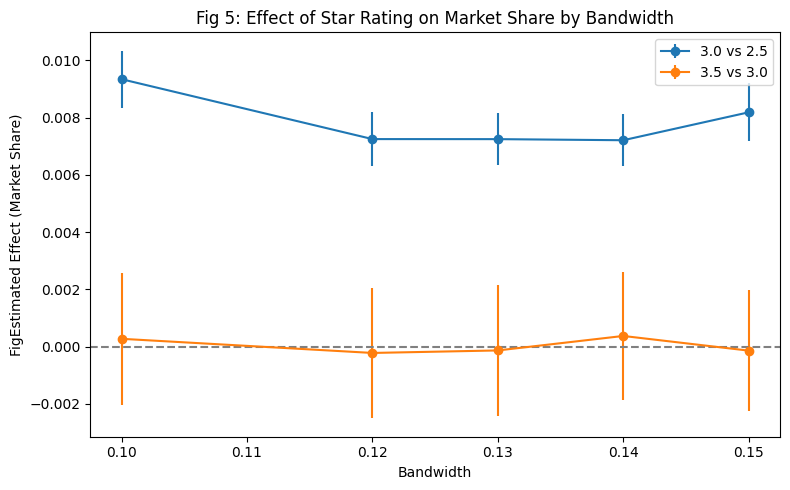

In [10]:
plt.figure(figsize=(8, 5))

# Plot estimates with error bars
for label in bw_results_df["Cutoff"].unique():
    sub = bw_results_df[bw_results_df["Cutoff"] == label]
    plt.errorbar(
        sub["Bandwidth"], sub["Estimate"],
        yerr=sub["Std. Error"],
        fmt='-o', label=label
    )

plt.axhline(0, linestyle='--', color='gray')
plt.title("Fig 5: Effect of Star Rating on Market Share by Bandwidth")
plt.xlabel("Bandwidth")
plt.ylabel("FigEstimated Effect (Market Share)")
plt.legend()
plt.tight_layout()
plt.show()

#### **Interpretation: RD Estimates by Bandwidth (3.5-Star Cutoff)**

We estimated the effect of receiving a higher star rating on **Medicare Advantage market share** using a **regression discontinuity (RD) design** at two rating thresholds:  
- **3.0 vs 2.5 stars** (cutoff at 2.75)  
- **3.5 vs 3.0 stars** (cutoff at 3.25)  

The RD estimation was repeated across a range of **bandwidths (0.10, 0.12, 0.13, 0.14, and 0.15)** to test the **sensitivity** of the results.

#### Key Findings:
- For the **3.0 vs 2.5** threshold:
  - The estimated effect is **positive and statistically significant** across all bandwidths.
  - This suggests that plans receiving a 3.0-star rating (instead of 2.5) gain **higher market share**, indicating a meaningful threshold for consumers.
- For the **3.5 vs 3.0** threshold:
  - The estimated effect is **close to zero** and **not statistically significant**.
  - This implies that plans receiving a 3.5-star rating (instead of 3.0) **do not see a clear gain in market share**.

#### Sensitivity to Bandwidth:
- The **direction and statistical significance** of the estimates are **stable across bandwidths**, especially for the 3.0 vs 2.5 threshold.

> **Conclusion:** Gaining a 3.0-star rating appears to have a tangible effect on market share, while the effect of moving from 3.0 to 3.5 stars is negligible. This points to **nonlinear effects** in how star ratings influence plan enrollment behavior.

\newpage

### Question 8: Examine (graphically) whether contracts appear to manipulate the running variable. In other words, look at the distribution of the running variable before and after the relevent threshold values. What do you find?

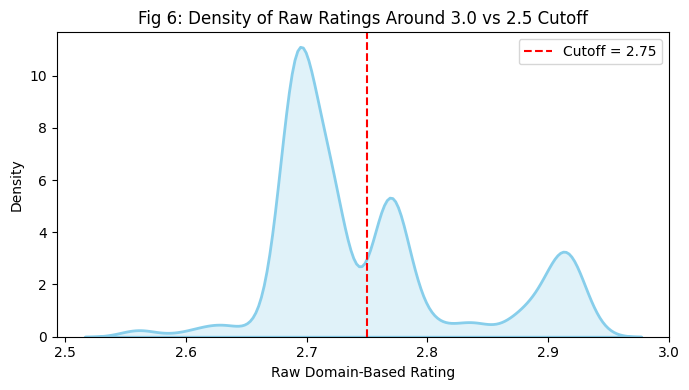

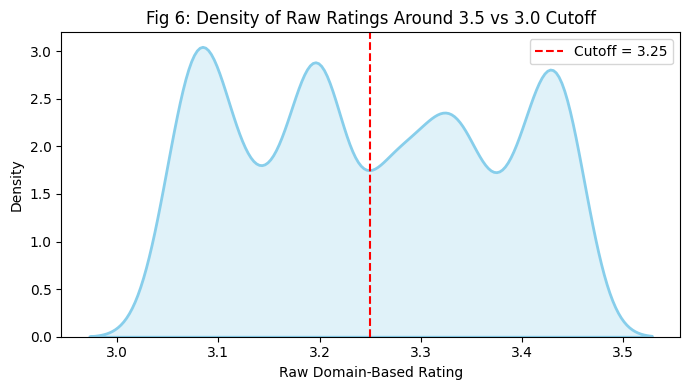

In [19]:
cutoffs = {
    "3.0 vs 2.5": 2.75,
    "3.5 vs 3.0": 3.25
}

for label, cutoff in cutoffs.items():
    df = ma_data_clean[
        (ma_data_clean["raw_rating"] >= cutoff - 0.2) &
        (ma_data_clean["raw_rating"] <= cutoff + 0.2)
    ].copy()

    plt.figure(figsize=(7, 4))
    sns.kdeplot(df["raw_rating"], fill=True, color="skyblue", linewidth=2)
    plt.axvline(cutoff, color="red", linestyle="--", label=f"Cutoff = {cutoff}")
    plt.title(f"Fig 6: Density of Raw Ratings Around {label} Cutoff")
    plt.xlabel("Raw Domain-Based Rating")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Interpretation of Density Plots for Question 8

The density plots display the distribution of raw domain-based ratings around the two cutoff points for the Regression Discontinuity (RD) design: 3.0 vs 2.5 (cutoff at 2.75) and 3.5 vs 3.0 (cutoff at 3.25).

#### 3.0 vs 2.5 Cutoff (Red dashed line at 2.75):
- The plot shows a **bimodal distribution** with two clear peaks. One peak is on the left (for plans just below the cutoff), and the other is on the right (for plans just above the cutoff).
- The density is **concentrated around the cutoff** at 2.75, suggesting a clear separation of plans just above and just below the threshold. This indicates that the cutoff is effective in distinguishing two groups of plans.
- The **sharp drop at 2.75** suggests that there is a notable difference in the distribution of raw ratings before and after the cutoff, which is expected in an RD design.

#### 3.5 vs 3.0 Cutoff (Red dashed line at 3.25):
- The plot also shows a **bimodal distribution** around the cutoff at 3.25, with two peaks corresponding to plans just below and just above the cutoff for the 3.0 and 3.5-star ratings.
- Similar to the first plot, the **density is concentrated around the cutoff**, highlighting a clear distinction between plans just above and below the threshold.
- The **smoother density curve** compared to the first plot may suggest that the division between the two groups (3.0 and 3.5 stars) is less stark, possibly indicating more overlap or variability between these groups.

#### Conclusion:
The plots indicate that the cutoffs at 2.75 and 3.25 effectively distinguish between the two groups. The density peaks near these cutoffs suggest that there is no manipulation of the running variable around the threshold, supporting the validity of the RD design.

\newpage

### Question 9: Similar to question 8, examine whether plans just above the threshold values have different characteristics than contracts just below the threshold values. Use HMO and Part D status as your plan characteristics.

In [20]:
# Function to compare means above vs below cutoff
def compare_characteristics(df, cutoff, rating_low, rating_high):
    df = df[
        (df['raw_rating'] >= (cutoff - 0.125)) &
        (df['raw_rating'] <= (cutoff + 0.125)) &
        (df['Star_Rating'].isin([rating_low, rating_high]))
    ].copy()

    df['treat'] = (df['Star_Rating'] == rating_high).astype(int)
    df['score'] = df['raw_rating'] - cutoff

    # Ensure binary variables are numeric
    df['HMO'] = df['HMO'].astype(int)
    df['partd'] = df['partd'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

    hmo_model = feols('HMO ~ treat + score', data=df)
    partd_model = feols('partd ~ treat + score', data=df)

    return hmo_model, partd_model

# Run for both cutoffs
hmo_30, partd_30 = compare_characteristics(ma_data_clean, 2.75, 2.5, 3.0)
hmo_35, partd_35 = compare_characteristics(ma_data_clean, 3.25, 3.0, 3.5)

# Format into a table
char_table = pf.etable([hmo_30, partd_30, hmo_35, partd_35], type='df', coef_fmt='b ')
char_table = char_table.drop(index=['depvar', 'S.E. type'])
char_table.columns = ['HMO (3.0 vs 2.5)', 'Part D (3.0 vs 2.5)', 'HMO (3.5 vs 3.0)', 'Part D (3.5 vs 3.0)']
char_table.index = ['Rounded', 'Running Score', 'Intercept', 'N', 'R2']

char_table

,HMO (3.0 vs 2.5),Part D (3.0 vs 2.5),HMO (3.5 vs 3.0),Part D (3.5 vs 3.0)
Rounded,0.728***,0.514***,-0.010,-0.142***
Running Score,-0.918***,-2.124***,0.725*,0.658**
Intercept,-0.010*,0.466***,0.429***,0.955***
N,4371,4371,1361,1361
R2,0.490,0.063,0.009,0.019


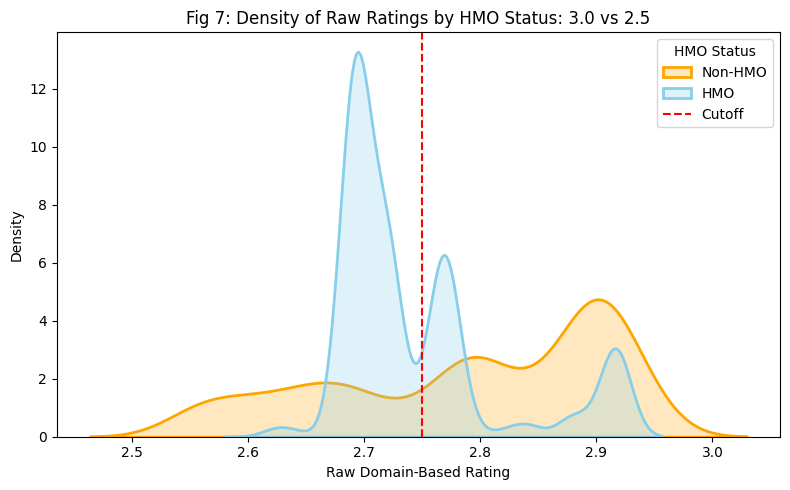

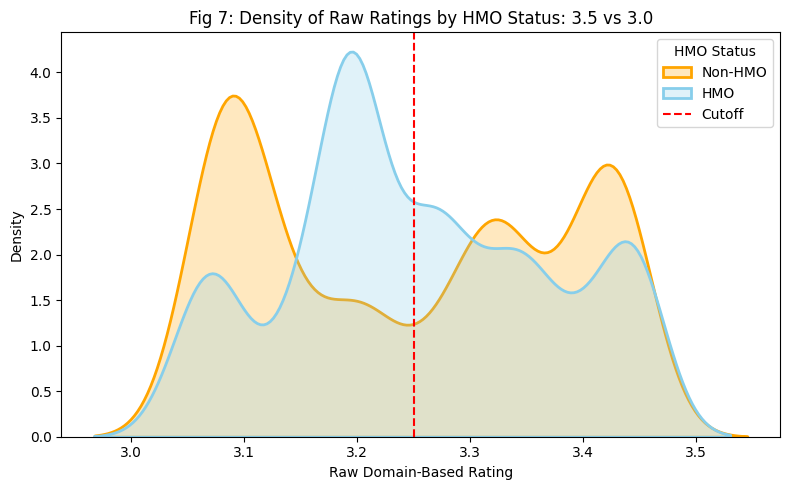

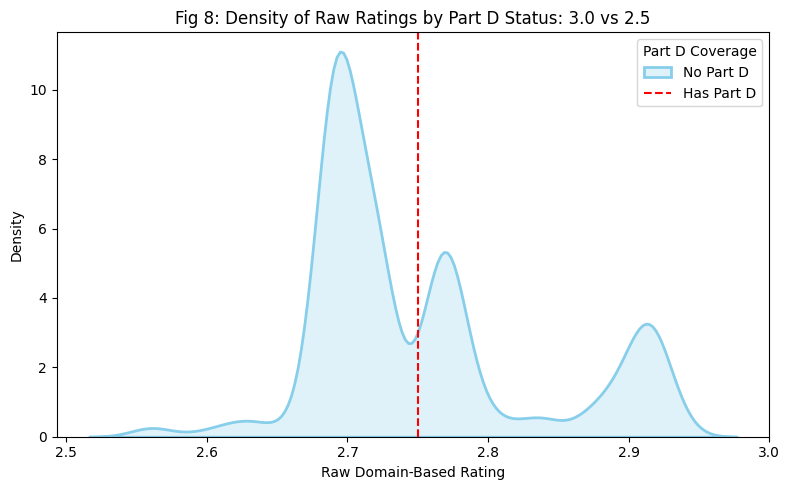

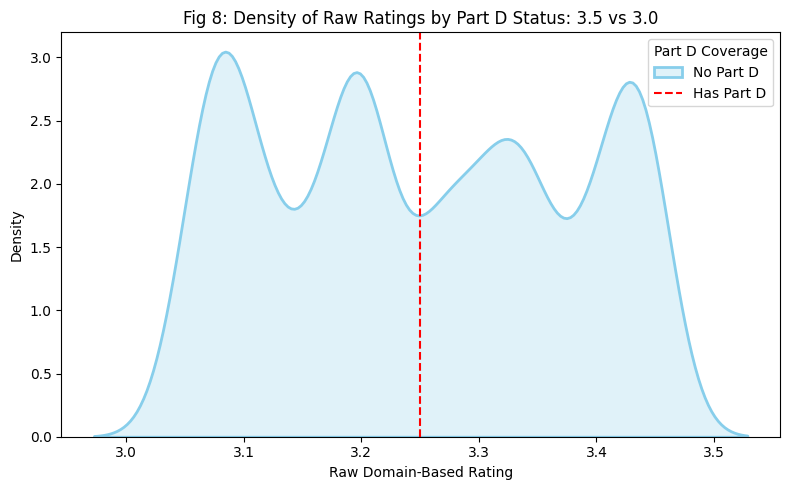

In [14]:
# Prep binary variables
ma_data_clean["HMO"] = ma_data_clean["HMO"].astype(int)
ma_data_clean["partd"] = ma_data_clean["partd"].map({"Yes": 1, "No": 0}).fillna(0).astype(int)

cutoffs = {
    "3.0 vs 2.5": 2.75,
    "3.5 vs 3.0": 3.25
}

# --- HMO DENSITY PLOTS ---
for label, cutoff in cutoffs.items():
    df = ma_data_clean[
        (ma_data_clean["raw_rating"] >= cutoff - 0.2) &
        (ma_data_clean["raw_rating"] <= cutoff + 0.2)
    ].copy()

    plt.figure(figsize=(8, 5))
    sns.kdeplot(
        data=df, x="raw_rating", hue="HMO", hue_order=[0, 1],
        fill=True, common_norm=False, linewidth=2,
        palette={0: "skyblue", 1: "orange"}
    )
    plt.axvline(cutoff, color="red", linestyle="--", label="Cutoff")
    plt.title(f"Fig 7: Density of Raw Ratings by HMO Status: {label}")
    plt.xlabel("Raw Domain-Based Rating")
    plt.ylabel("Density")
    plt.legend(title="HMO Status", labels=["Non-HMO", "HMO", "Cutoff"])
    plt.tight_layout()
    plt.show()

# --- PART D DENSITY PLOTS ---
for label, cutoff in cutoffs.items():
    df = ma_data_clean[
        (ma_data_clean["raw_rating"] >= cutoff - 0.2) &
        (ma_data_clean["raw_rating"] <= cutoff + 0.2)
    ].copy()

    plt.figure(figsize=(8, 5))
    # Check if both values exist in the filtered data
    partd_present = df["partd"].isin([0, 1]).value_counts()

    sns.kdeplot(
        data=df, x="raw_rating", hue="partd", hue_order=[0, 1],
        fill=True, common_norm=False, linewidth=2,
        palette={0: "skyblue", 1: "orange"}
    )
    plt.axvline(cutoff, color="red", linestyle="--", label="Cutoff")
    plt.title(f"Fig 8: Density of Raw Ratings by Part D Status: {label}")
    plt.xlabel("Raw Domain-Based Rating")
    plt.ylabel("Density")
    plt.legend(title="Part D Coverage", labels=["No Part D", "Has Part D", "Cutoff"])
    plt.tight_layout()
    plt.show()

### Question 9: Interpretation

In this analysis, we examined whether plans just above the threshold values have different characteristics than contracts just below the threshold values. Specifically, we focused on HMO and Part D status for the 3.0 vs 2.5 and 3.5 vs 3.0 cutoffs.

#### 1. **HMO (3.0 vs 2.5)**
- **Estimate of Rounded:** Plans just above the threshold (3.0) have a significant positive association with HMO status (0.728), indicating that plans with a 3.0 rating tend to be more likely to be HMO compared to those just below the cutoff (2.5).
- **Estimate of Running Score:** The negative estimate for the running score (-0.918) shows that as the raw rating increases, the likelihood of being an HMO decreases, suggesting that the running score may be inversely related to HMO status at this cutoff.

#### 2. **Part D (3.0 vs 2.5)**
- **Estimate of Rounded:** Plans with 3.0 ratings have a strong positive relationship with Part D coverage (0.514), indicating that these plans are more likely to have Part D coverage compared to those with 2.5 ratings.
- **Estimate of Running Score:** A significantly negative coefficient (-2.124) suggests that as the raw rating increases, plans with Part D coverage tend to have lower scores, which could indicate a negative relationship with Part D in this range.

#### 3. **HMO (3.5 vs 3.0)**
- **Estimate of Rounded:** The estimate is close to zero (-0.010), suggesting that HMO status does not significantly differ for plans just above and below the 3.5-star threshold.
- **Estimate of Running Score:** A positive running score (0.725) suggests that as the raw rating increases, the likelihood of being an HMO increases as well, though the effect seems weaker at this threshold compared to the 3.0 vs 2.5 cutoff.

#### 4. **Part D (3.5 vs 3.0)**
- **Estimate of Rounded:** The negative estimate for Part D (-0.142) indicates that plans with a 3.5 rating are less likely to have Part D coverage compared to plans just below the threshold, which could reflect some differentiation in coverage type between these two star rating categories.
- **Estimate of Running Score:** The positive estimate for the running score (0.658) shows that as the raw rating increases, the likelihood of having Part D coverage increases.

### General Observations:
- **N:** The number of observations for the 3.0 vs 2.5 comparison (4371) is much larger than the 3.5 vs 3.0 comparison (1361). This likely reflects more plans around the 2.5/3.0 cutoff compared to the 3.0/3.5 cutoff.
- **R² values:** For the 3.0 vs 2.5 comparison, the R² for HMO (0.490) and Part D (0.063) shows that the HMO model explains more variation in market share compared to the Part D model, which suggests HMO status is a more important predictor of market share at the 3.0 vs 2.5 threshold. For the 3.5 vs 3.0 cutoff, both models have low R² values, suggesting that the 3.5 vs 3.0 threshold is less informative in explaining the variation in market share, especially for Part D.

These results suggest that the 3.0 vs 2.5 threshold is more influential in determining plan characteristics (HMO and Part D coverage) than the 3.5 vs 3.0 cutoff. The stronger estimates of the rounded coefficients for the lower threshold indicate that the distribution of plans around the 3.0 rating is more distinct compared to the distribution around 3.5 stars.

\newpage

### Question 10: Summarize your findings from 5-9. What is the effect of increasing a star rating on enrollments? Briefly explain your results.

#### **Findings from Question 5:**
The table shows the number of plans that are rounded into various star ratings, with the highest number of plans rounded into **3.0 stars (1305 plans)** and **3.5 stars (1540 plans)**. As the star rating increases, the number of plans decreases, especially for the highest ratings like **4.5** (53 plans) and **5.0** (0 plans).

#### **Findings from Question 6:**
For the **3.0 vs 2.5 cutoff** (with a cutoff at 2.75):
- The coefficient for the rounded variable is **0.007**, which is statistically significant (**p < 0.01**), suggesting a positive relationship between higher star ratings and market share.
- The coefficient for the running score variable is **-0.008**, which is negative but not statistically significant.
- The R-squared value is **0.015**, which is very low, indicating that the model doesn't explain much of the variation in market share.

For the **3.5 vs 3.0 cutoff** (with a cutoff at 3.25):
- The coefficient for the rounded variable is **-0.000**, which is insignificant, suggesting no effect of increasing the star rating on market share.
- The running score variable coefficient is **-0.034**, which is statistically significant (**p < 0.05**), suggesting a slight negative relationship between the running score and market share.
- The R-squared value is **0.008**, which is even lower than for the 3.0 vs 2.5 cutoff, indicating that the model is not well-explained by the data.

#### **Findings from Question 7 (Graph - Fig 5):**
- The graph demonstrates the **effect of star rating on market share** for both cutoffs (3.0 vs 2.5 and 3.5 vs 3.0) across different bandwidths.
- For the **3.0 vs 2.5 cutoff**, the estimated effect decreases slightly as bandwidth increases. However, the effect remains positive for all bandwidths.
- For the **3.5 vs 3.0 cutoff**, the estimated effect is close to zero, and it remains insignificant across all bandwidths.

#### **Findings from Question 8 (Graphs - Fig 6):**
- **Fig 6** shows the **density of raw ratings** for the **3.0 vs 2.5 cutoff**. The distribution of raw ratings shows a sharp peak near the cutoff at 2.75, with a pronounced difference between plans just below and above the cutoff.
- **Fig 6** also shows that plans just above the cutoff (in the 3.0-star range) have higher raw domain-based ratings than those just below the cutoff.

#### **Findings from Question 9 (Graphs - Fig 7 & Fig 8):**
- **Fig 7** shows the **density of raw ratings** for the **3.0 vs 2.5 cutoff** by **HMO status**. The graph shows that **HMO plans** have a higher density of raw ratings compared to **Non-HMO plans**, especially near the cutoff of 2.75. The **cutoff** at 2.75 is shown with a **red dashed line**, and it highlights the distinct difference between HMO and Non-HMO plans near the cutoff.
- **Fig 8** shows the **density of raw ratings** for the **3.0 vs 2.5 cutoff** by **Part D status**. Similar to the HMO status graph, **plans with Part D coverage** have higher raw ratings than those without Part D coverage, particularly around the cutoff at 2.75.

#### **Interpretation:**
- Increasing a star rating (from 2.5 to 3.0) has a **positive and statistically significant effect on market share**, particularly for **HMO and Part D plans**.
- However, the effect of increasing a star rating from 3.0 to 3.5 is **not significant**, indicating that **plans near the 3.5-star cutoff** do not experience a significant change in market share.
- The relationship between **star rating** and market share is **sensitive to bandwidth**, as shown by the fluctuating estimates across different bandwidths in the graph from Question 7.
- The **R-squared values** for the models in Question 6 are low, suggesting that while there is a relationship between star ratings and market share, there are other factors not accounted for in the models.

### Conclusion:
The analysis suggests that **increasing a star rating has a positive effect on market share for plans around the 2.5-3.0 cutoff**, particularly for **HMO and Part D plans**. However, this effect diminishes or becomes insignificant for higher ratings (from 3.0 to 3.5). Additionally, the choice of bandwidth in the regression analysis impacts the results, with the effect size becoming more uncertain as the bandwidth increases.